  This notebook demonstrates adversarial attacks (PGD) on a simple image classification task using the CIFAR10 dataset

  This will train two models (a simple CNN and a pre-trained ResNet18) and investigate the transferability of adversarial examples between them

  ## 1. Environment Setup and Data Loading

In [1]:
%load_ext autoreload
%autoreload 2
import os
import json
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from models import SimpleCNN, ResNet18, ViT
from train import get_dataloader, simple_train
from eval import test, pgd_attack
from pathlib import Path
import seaborn as sns
from models import LlamaVision


In [2]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")    
dataset = "CIFAR-10"
trainloader = get_dataloader(dataset, batch_size=128, train=True)
testloader = get_dataloader(dataset, batch_size=128, train=False)

# get number of labels in training set
num_classes = len(trainloader.dataset.classes)
print(f'# of classes: {num_classes}')


Files already downloaded and verified
Files already downloaded and verified
# of classes: 10


  ## 2. Model Selection and Training

  ### Model A: Simple CNN

In [4]:
model_a = SimpleCNN(num_classes).to(dev)

# Load saved model if exists, otherwise train
if Path('model_a.pth').exists():
    model_a.load_state_dict(torch.load('model_a.pth', weights_only=True))
else:
    simple_train(trainloader, model_a, dev, save_path='model_a.pth', lr=0.01, epochs=50)
model_a = model_a.eval()

  ### Model B: Pre-trained ResNet18 (fine tuned for CIFAR-10)

In [5]:
model_b = ResNet18(num_classes).to(dev)

# Load saved model if exists, otherwise train
if Path('model_b.pth').exists():
    model_b.load_state_dict(torch.load('model_b.pth', weights_only=True))
else:
    # Freeze all layers
    for param in model_b.model.parameters():
        param.requires_grad = False
        
    # Unfreeze layer4 and classifier layer
    for param in model_b.model.layer4.parameters():
        param.requires_grad = True
    for param in model_b.model.fc.parameters():
        param.requires_grad = True
    
    simple_train(trainloader, model_b, dev, save_path='model_b.pth', lr=0.001, epochs=1)
model_b = model_b.eval()


  ### Model C: Vision Transformer (ViT)

In [6]:
model_c = ViT(num_classes).to(dev)

# Load saved model if exists, otherwise train
if Path('model_c.pth').exists():
    model_c.load_state_dict(torch.load('model_c.pth', weights_only=True))
else:
    simple_train(trainloader, model_c, dev, save_path='model_c.pth', lr=0.01, epochs=50)
model_c = model_c.eval()

 ## 3. Generate and Evaluate Adversarial Examples

 ### Projected Gradient Descent (PGD)

 ### Evaluate Model A

In [7]:
# Set attack parameters
epsilon = 0.03  
alpha = 0.01   
num_iter = 10  
attack = "pgd"

In [8]:
model_a_info = {'CNN': model_a}
clean_acc_a = test(model_a_info, testloader, dev)['CNN']
pgd_acc_a = test(model_a_info, testloader, dev, attack=attack, epsilon=epsilon, 
                 alpha=alpha, num_iter=num_iter)['CNN']

print(f"Model A (Simple CNN) - Clean accuracy: {clean_acc_a:.2f}%")
print(f"Model A (Simple CNN) - PGD accuracy: {pgd_acc_a:.2f}%")


Model A (Simple CNN) - Clean accuracy: 64.59%
Model A (Simple CNN) - PGD accuracy: 6.87%


 ### Evaluate Model B

In [9]:
model_b_info = {'ResNet': model_b}
clean_acc_b = test(model_b_info, testloader, dev)['ResNet']
pgd_acc_b = test(model_b_info, testloader, dev, attack=attack, epsilon=epsilon, 
                 alpha=alpha, num_iter=num_iter)['ResNet']

print(f"Model B (ResNet18) - Clean accuracy: {clean_acc_b:.2f}%")
print(f"Model B (ResNet18) - PGD accuracy: {pgd_acc_b:.2f}%")


Model B (ResNet18) - Clean accuracy: 69.45%
Model B (ResNet18) - PGD accuracy: 5.90%


 ### Evaluate Model C

In [10]:
model_c_info = {'ViT': model_c}
clean_acc_c = test(model_c_info, testloader, dev)['ViT']
pgd_acc_c = test(model_c_info, testloader, dev, attack=attack, epsilon=epsilon, 
                 alpha=alpha, num_iter=num_iter)['ViT']

print(f"Model C (Vision Transformer) - Clean accuracy: {clean_acc_c:.2f}%")
print(f"Model C (Vision Transformer) - PGD accuracy: {pgd_acc_c:.2f}%")


Model C (Vision Transformer) - Clean accuracy: 66.27%
Model C (Vision Transformer) - PGD accuracy: 5.95%


 ### Visualization (using Model A for demonstration)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.5654321].


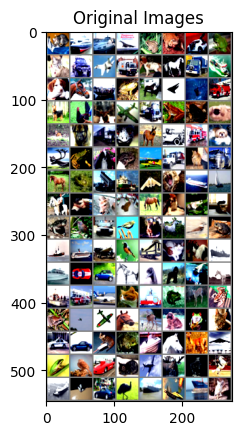

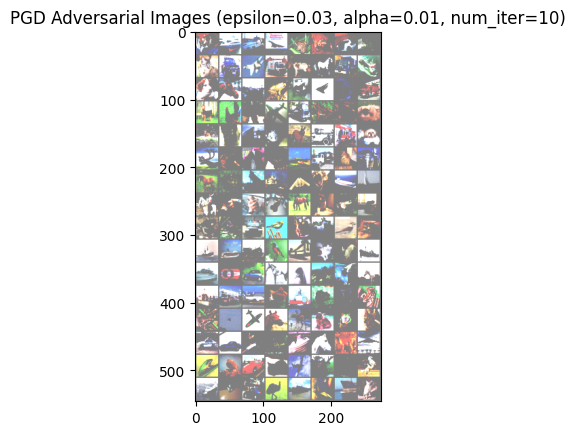

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06543207..1.4947369].


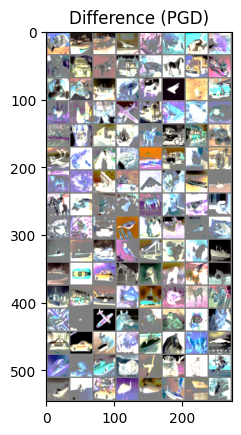

In [11]:
# Get a batch of test data
dataiter = iter(testloader)
images, labels = next(dataiter)

images = images.to(dev)
labels = labels.to(dev)
# Generate adversarial examples
adv_pgd = pgd_attack(model_a, images, labels, epsilon, alpha, num_iter)

# De-normalize a batch of images for visualization
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()
    
images = images.cpu()
adv_pgd = adv_pgd.cpu()
imshow(torchvision.utils.make_grid(images), "Original Images")
imshow(torchvision.utils.make_grid(adv_pgd), f"PGD Adversarial Images (epsilon={epsilon}, alpha={alpha}, num_iter={num_iter})")
imshow(torchvision.utils.make_grid(adv_pgd - images), "Difference (PGD)")


 ## 4. Transferability Analysis

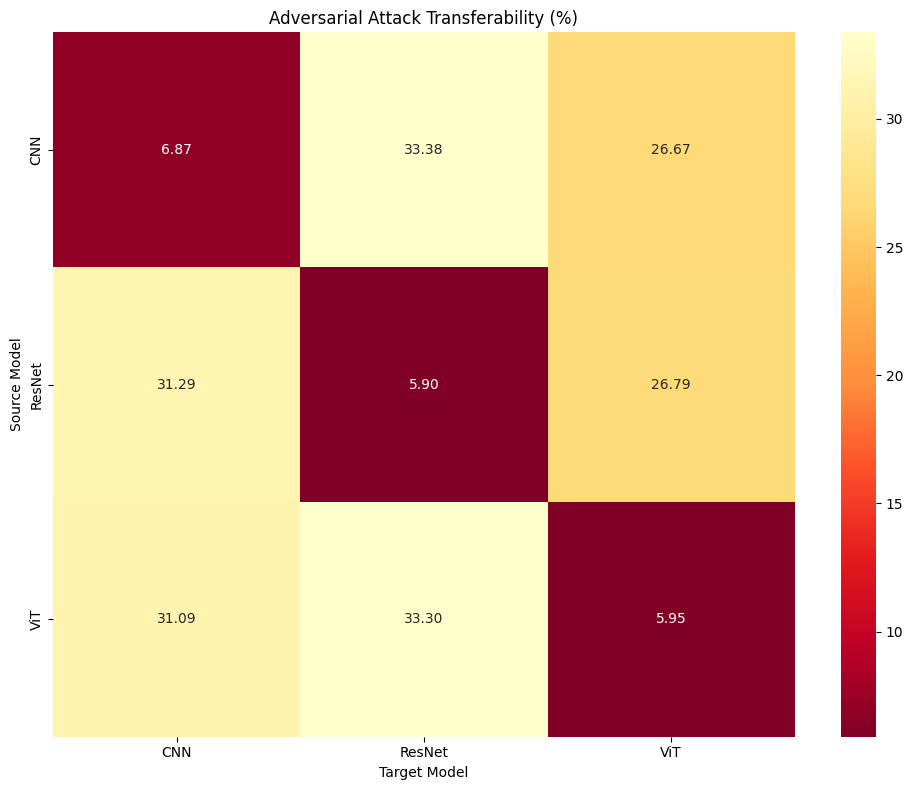


Transferability Analysis Results:
--------------------------------
Attack from CNN to ResNet: 33.38%
Attack from CNN to ViT: 26.67%
Attack from ResNet to CNN: 31.29%
Attack from ResNet to ViT: 26.79%
Attack from ViT to CNN: 31.09%
Attack from ViT to ResNet: 33.30%


In [12]:
# Setup models and names
models = [model_a, model_b, model_c]
model_names = ['CNN', 'ResNet', 'ViT']
self_pgd_accs = [pgd_acc_a, pgd_acc_b, pgd_acc_c]

# Evaluate transferability of adversarial examples between models
results = np.zeros((len(models), len(models)))
for i, model_attack in enumerate(models):
    models_to_eval = {name: model for name, model in zip(model_names, models) if name != model_names[i]}
    accs = test(models_to_eval, testloader, dev, model_to_train_attack=model_attack, 
                attack="pgd", epsilon=epsilon, alpha=alpha, num_iter=num_iter)

    for j, name in enumerate(model_names):
        results[i][j] = self_pgd_accs[i] if i == j else accs[name]
    
# Display transferability results
plt.figure(figsize=(10, 8))
sns.heatmap(results, annot=True, fmt='.2f', 
            xticklabels=model_names,
            yticklabels=model_names,
            cmap='YlOrRd_r')
plt.title('Adversarial Attack Transferability (%)')
plt.xlabel('Target Model')
plt.ylabel('Source Model')
plt.tight_layout()
plt.show()

# Print results
print("\nTransferability Analysis Results:")
print("--------------------------------")
for i in range(len(models)):
    for j in range(len(models)):
        if i != j:
            print(f"Attack from {model_names[i]} to {model_names[j]}: {results[i][j]:.2f}%")


In [13]:
classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
results_file = "llama_vision_results.json"

In [14]:
vlm = LlamaVision(classes=classes)
if not Path(results_file).exists():
    # Need to be logged in to Hugging Face to use this model
    data_percentage = 0.02

    testloader = get_dataloader(dataset, batch_size=1, train=False, 
                                norm=False, stratified_sample=data_percentage)
    vlm_model_info = {'llamavision': vlm}
    
    
    clean_acc_vlm = test(vlm_model_info, testloader, dev)['llamavision']
    
    all_pgd_accs_vlm = []
    for i, model in enumerate(models):
        all_pgd_accs_vlm.append(test(vlm_model_info, testloader, dev, attack=attack, epsilon=epsilon, 
                                model_to_train_attack=model,alpha=alpha, num_iter=num_iter)['llamavision'])
        
    llama_vision_results = {
        "clean_accuracy": clean_acc_vlm,
        "pgd_accuracies": {model_names[i]: all_pgd_accs_vlm[i] for i in range(len(models))}
    }

    with open("llama_vision_results.json", "w") as f:
        json.dump(llama_vision_results, f, indent=4)
else:
    with open(results_file, "r") as f:
        llama_vision_results = json.load(f)

    clean_acc_vlm = llama_vision_results["clean_accuracy"]
    all_pgd_accs_vlm = [llama_vision_results["pgd_accuracies"][name] for name in model_names]

    print(f"Llama Vision results loaded from {results_file}")
    print()
        
print(f"Model D (Llama Vision) - Clean accuracy: {clean_acc_vlm:.2f}%")
for i, acc in enumerate(all_pgd_accs_vlm):
    print(f"Model D (Llama Vision) - PGD trained on {model_names[i]} Accuracy: {acc:.2f}%")


The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu and disk.


Llama Vision results loaded from llama_vision_results.json

Model D (Llama Vision) - Clean accuracy: 9.00%
Model D (Llama Vision) - PGD trained on CNN Accuracy: 9.00%
Model D (Llama Vision) - PGD trained on ResNet Accuracy: 9.00%
Model D (Llama Vision) - PGD trained on ViT Accuracy: 8.00%


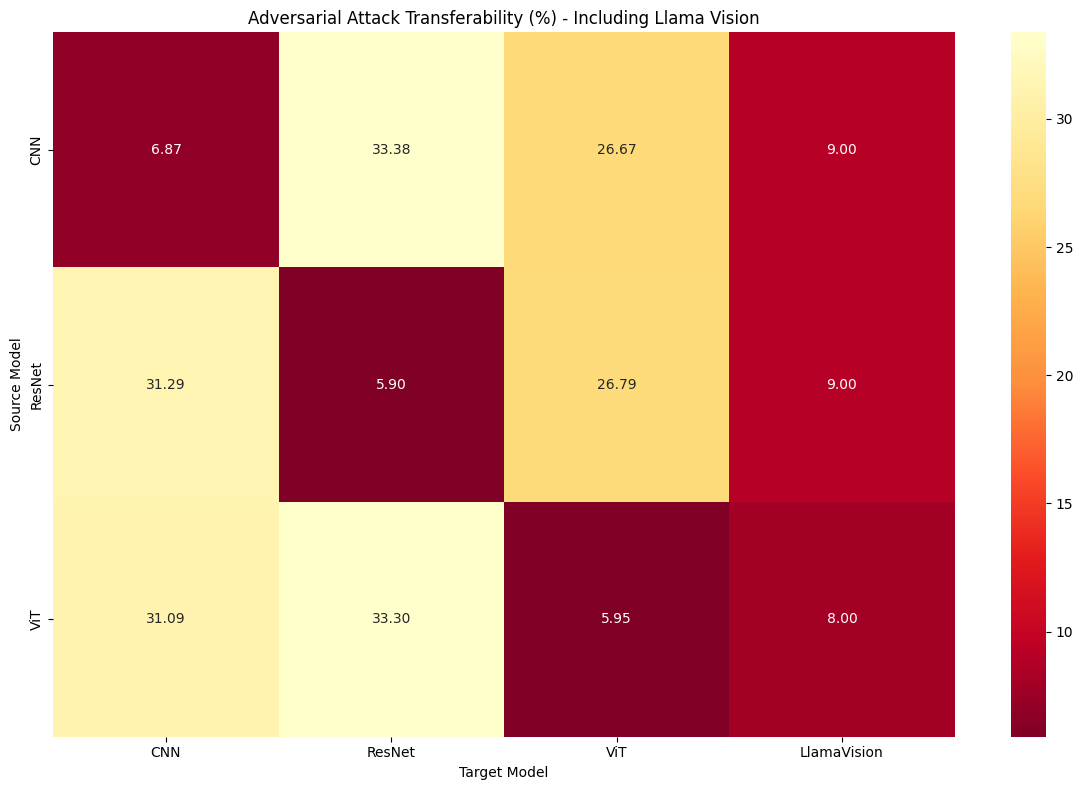


Updated Transferability Analysis Results (Including Llama Vision):
-----------------------------------------------------------------
Attack from CNN to CNN: 6.87%
Attack from CNN to ResNet: 33.38%
Attack from CNN to ViT: 26.67%
Accuracy of LlamaVision when attacked by CNN: 9.00%
Attack from ResNet to CNN: 31.29%
Attack from ResNet to ResNet: 5.90%
Attack from ResNet to ViT: 26.79%
Accuracy of LlamaVision when attacked by ResNet: 9.00%
Attack from ViT to CNN: 31.09%
Attack from ViT to ResNet: 33.30%
Attack from ViT to ViT: 5.95%
Accuracy of LlamaVision when attacked by ViT: 8.00%


In [15]:
# Add the Llama Vision results to the previous transferability plots
model_names.append('LlamaVision')

# Expand results matrix to include Llama Vision (only as a target)
new_results = np.zeros((len(models), len(models) + 1)) # +1 for Llama Vision

# Fill in the existing results
new_results[:, :len(models)] = results

# Add Llama Vision results
new_results[:, -1] = all_pgd_accs_vlm

# Display transferability results with Llama Vision
plt.figure(figsize=(12, 8))
sns.heatmap(new_results, annot=True, fmt='.2f',
            xticklabels=model_names,
            yticklabels=model_names[:-1],
            cmap='YlOrRd_r')
plt.title('Adversarial Attack Transferability (%) - Including Llama Vision')
plt.xlabel('Target Model')
plt.ylabel('Source Model')
plt.tight_layout()
plt.show()

# Print updated results
print("\nUpdated Transferability Analysis Results (Including Llama Vision):")
print("-----------------------------------------------------------------")
for i in range(len(models)):
    for j in range(len(models) + 1):
        if j < len(models):
            # Transferability from CNN, ResNet, ViT to other models
            print(f"Attack from {model_names[i]} to {model_names[j]}: {new_results[i][j]:.2f}%")
        else:
            # Accuracy of Llama Vision when attacked by CNN, ResNet, ViT
            print(f"Accuracy of {model_names[j]} when attacked by {model_names[i]}: {new_results[i][j]:.2f}%")